# Required packages

In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt
import itertools
import math

from scipy.linalg import svd
%matplotlib notebook

# Dataset

In [4]:
loc_training = np.loadtxt(fname = "C:\\Users\\kssfv\\Downloads\\UJIndoorLoc\\UJIndoorLoc\\trainingData.csv", skiprows = 1, delimiter=",")

loc_training_data = loc_training[: , : 520]
loc_training_target = loc_training[:, 520 :]

# 1. Principal Component Analysis using Singular Vector Decomposition

In [5]:
#Centering data with respect to mean and scaling it to a standard ratio.
centered_data = (loc_training_data - np.mean(loc_training_data, axis = 0)) / (np.std(loc_training_data, axis = 0) + 0.00001)

#Calculating Singular Vector Decomposition for 
u, s, v = svd(centered_data, full_matrices = False)

PCA = (u[:, :2] * s[:2] * np.std(loc_training_data, axis = 0)[:2]) + np.mean(loc_training_data, axis = 0)[:2]
PCA3D = (u[:, :3] * s[:3] * np.std(loc_training_data, axis = 0)[:3]) + np.mean(loc_training_data, axis = 0)[:3]

<IPython.core.display.Javascript object>


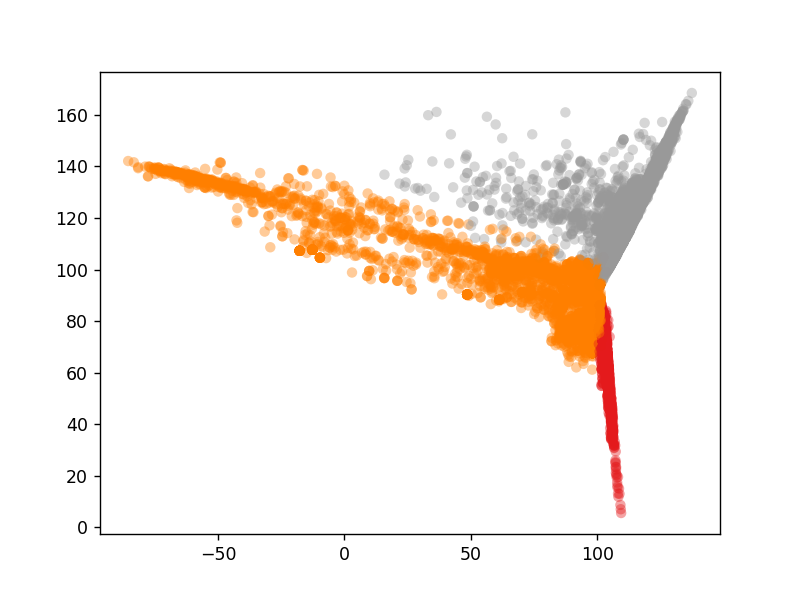

<IPython.core.display.Javascript object>


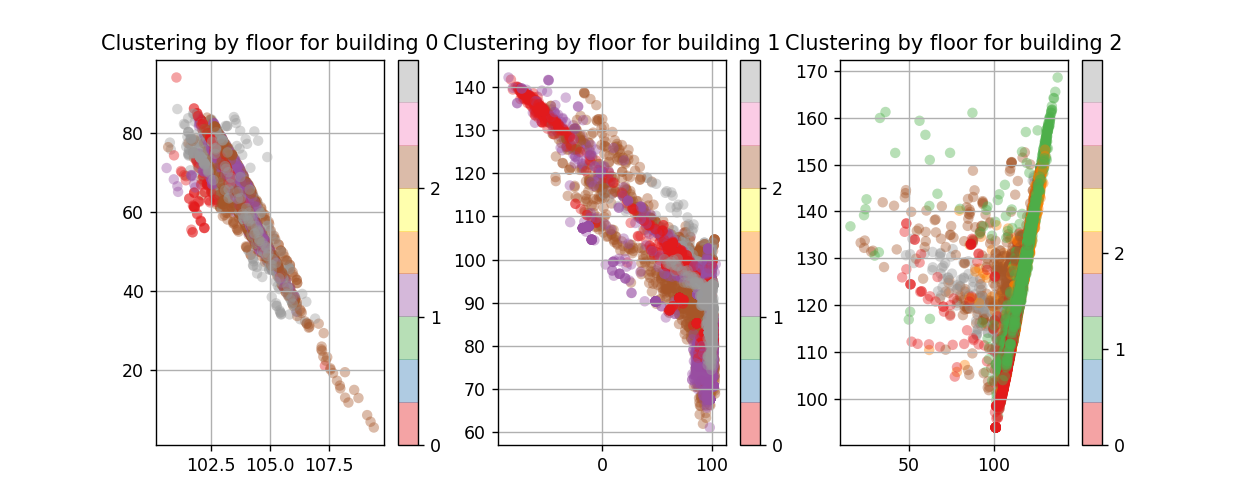

In [6]:
# Plotting the PCA of WAP ponts and classifying according to different criteria
f = plt.figure("Clustering by building")
a = plt.axes()
a.scatter(PCA[:,:1], PCA[:,1:2], edgecolors='none', c = loc_training_target[: , 3: 4], alpha=0.4, cmap = 'Set1');

fig, ax = plt.subplots(1, 3, figsize=(10, 4), num = "Floor pairplot")


for i in range(3):
    c = loc_training_target[np.where((loc_training_target[: , 3: 4] == i))[0],2].reshape(-1, 1)
    ax[i].grid(True)

    sel_points = PCA[np.where((loc_training_target[: , 3: 4] == i).all(axis=1))]
    im = ax[i].scatter(sel_points[:,:1], sel_points[:,1:2], edgecolors='none', c = c, alpha=0.4, cmap = 'Set1')
    cbar = fig.colorbar(im, ax = ax[i])
    cbar.set_ticks(np.unique(loc_training_target[:,3]))
    ax[i].set_title('Clustering by floor for building ' + str(i))


# 2. Feature Selection

In [7]:
#Eliminating all columns with no access to any user location i.e signal strength is 100 for all sample points
unused_locations = np.where(np.all(loc_training_data == loc_training_data[0,:], axis = 0))

#Selecting more significant features where the standard deviation is greater than 4
more_used_features = np.where(np.std(loc_training_data, axis = 0) > 4)[0]
print('Selecting ',more_used_features.shape[0], 'as best required features. Eliminated ', loc_training_data.shape[1] - more_used_features.shape[0], 'features as less or non significant.')
loc_training_data_sig = loc_training_data[ : , more_used_features]

Selecting  394 as best required features. Eliminated  126 features as less or non significant.


#  K-Nearest Neighbors Algorithm

In [58]:
# Creating a nearest neighbors algorithm to predict the label of the point

class KNearestNeighbors(object):
        
    def points_distance(self, data, sample):
        """To calculate Euclidian distance between two points"""
        return np.sqrt(np.sum(((data - sample)**2), axis = 1))
    
    def fit(self, X_train, Y_train):
        """To fit the training data"""
        self.X_train = X_train
        self.Y_train = Y_train

    @staticmethod
    def nearest_neighbors(self, sample, k):
        """Generalised function to find the k-nearest neighbors."""
        indices = np.arange(self.X_train.shape[0])
        neighbors = self.points_distance(self.X_train, sample)
        neighbors = np.vstack((neighbors, indices)).T
        nearest_neighbors = neighbors[np.argsort(neighbors[:, 0])][:k]
        return nearest_neighbors

    def predict(self, sample, k):
        """Function to predict label of a sample point"""
        neighbors = self.nearest_neighbors(self, sample, k)[:,1].astype(np.int).tolist()
        floor_values, floor_counts = np.unique(self.Y_train[neighbors, 2], return_counts=True)
        pred_floor = floor_values[np.argmax(floor_counts)]
        building_values, building_counts = np.unique(self.Y_train[neighbors, 3], return_counts=True)
        pred_building = building_values[np.argmax(building_counts)]
        sample_prediction = [pred_floor, pred_building]
        return sample_prediction
        

    def score(self, X_test, Y_test, knn):
        """Function to calculate accuracy of the algorithm against a validation set"""
        if(type(knn) == list):
            accuracies = []
            for k in knn:
                error_floor = 0
                preds = []
                for index, sample in enumerate(X_test):
                    preds.append(self.predict(sample, k))
                np_preds = np.asarray(preds)
                accuracies.append(((np.sum(np_preds[:,0] == Y_test[:,2]) / Y_test[:,2].shape[0]) * 0.67 + (np.sum(np_preds[:,1] == Y_test[:,3]) / Y_test[:,3].shape[0]) * 0.33))
            return np.asarray(accuracies)
        else:
            preds = []
            for index, sample in enumerate(X_test):
                target = Y_test[index,0:4]  
                preds.append(self.predict(sample, knn))
            np_preds = np.asarray(preds)
            accuracy = ((np.sum(np_preds[:,0] == Y_test[:,2]) / Y_test[:,2].shape[0]) * 0.67 + (np.sum(np_preds[:,1] == Y_test[:,3]) / Y_test[:,3].shape[0]) * 0.33) 
            return np.asarray([accuracy])

        
#Performing cross-validation with multiple folds against the training dataset.
def knn_cv_score(data, target, folds, k):
    error_rates = []
    for fold in range(folds):
        train_data = []
        indices_train = random.sample(range(len(data)), int((len(data) + 1) * 0.80))
        indices_validation = filter(lambda s: s not in indices_train, list(range(0, len(data))))
        train_data = data[indices_train]
        validation_data = data[list(filter(lambda s: s not in indices_train, list(range(0, len(data)))))]
        train_target = target[indices_train]
        validation_target = target[list(filter(lambda s: s not in indices_train, list(range(0, len(data)))))]
        knn = KNearestNeighbors()
        knn.fit(train_data, train_target)
        knn_scores = knn.score(validation_data, validation_target, k)
        error_rates.append(1 - knn_scores)
    return np.array(error_rates)

# Clustered KNN (KNN over KMeans algorithm)

In [65]:
# Creating a clustered nearest neighbors algorithm to predict the label of the point

class clusteredKNN(object):

    def find_distances(self, sample, data):
        """To calculate Euclidian distance between two points"""
        return np.sqrt(np.sum(((data - sample)**2), axis = 1))
    
    def fit(self, X_train, Y_train, k):
        """To fit the training data into differet clusters or kmeans fitting"""
        length = X_train.shape[0]
        data = X_train
        points = random.sample(range(0, length), k)
        centroids = data[points,:]
        old_centroids = np.zeros(shape = (length, X_train.shape[1])) 
        clusters = np.zeros(length)
        while (centroids.any() != old_centroids.any()).any():
            for index, sample in enumerate(data):
                distances = self.find_distances(sample, centroids)
                clusters[index] = np.argmin(distances)
            for i in range(len(centroids)):
                centroids[i] = np.mean(data[np.where(clusters == i)], axis = 0)
            old_centroids = centroids
        self.X_train = X_train
        self.Y_train = Y_train
        self.clusters = clusters
        self.centroids = centroids
        
    def find_clusters(self):
        return self.clusters
    
    def find_centroids(self):
        return self.centroids
    
    def predict_knn(self, sample, k):
        """To predict the label of a sample point using knn over the delegated cluster"""
        delegate = np.argmin(self.find_distances(sample, self.centroids))
        X = self.X_train[np.where(self.clusters == delegate)]
        Y = self.Y_train[np.where(self.clusters == delegate)]
        if Y.size == 0:
            X = np.full((2, self.X_train.shape[1]), 100)
            Y = np.full((2, self.X_train.shape[1]), 0)
        knn = KNearestNeighbors()
        knn.fit(X, Y)
        return knn.predict(sample, k)
    
    def kmeans_knn_score(self, X_test, Y_test, k):
        """To calculate accuracy of the algorithm"""
        preds = []
        for index, sample in enumerate(X_test):
            preds.append(self.predict_knn(sample, k))
        np_preds = np.asarray(preds)
        return ((np.sum(np_preds[:,0] == Y_test[:,2]) / Y_test[:,2].shape[0]) * 0.67 + (np.sum(np_preds[:,1] == Y_test[:,3]) / Y_test[:,3].shape[0]) * 0.33)
    
#Performing cross-validation with multiple folds against the training dataset.
def kmeansknn_cv_score(data, target, folds, kmeans, knn):
    error_rates = []
    for fold in range(folds):
        train_data = []
        indices_train = random.sample(range(len(data)), int((len(data) + 1) * 0.80))
        indices_validation = filter(lambda s: s not in indices_train, list(range(0, len(data))))
        train_data = data[indices_train]
        validation_data = data[list(filter(lambda s: s not in indices_train, list(range(0, len(data)))))]
        train_target = target[indices_train]
        validation_target = target[list(filter(lambda s: s not in indices_train, list(range(0, len(data)))))]
        km = clusteredKNN()
        km_fit = km.fit(train_data, train_target, kmeans)
        scores = km.kmeans_knn_score(validation_data, validation_target, knn)
        error_rates.append(1 - scores)
    return np.array(error_rates)

# Linear Regression

In [50]:
# Creating linear regression algorithm to predict the label of the point

class LinearRegression(object):
        
    def points_distance(self, data, sample):
        """To calculate Euclidian distance between two points"""
        return np.sqrt(np.sum(((data - sample)**2), axis = 1))
    
    def fit(self, X_train, Y_train):
        """To fit the training data"""
        self.X_train = X_train
        self.Y_train_floor = Y_train[ : , 2]
        self.Y_train_building = Y_train[ : , 3]
        self.b_floor = np.linalg.inv((X_train.transpose().dot(X_train))).dot(X_train.transpose()).dot(self.Y_train_floor)
        self.b_building = np.linalg.inv((X_train.transpose().dot(X_train))).dot(X_train.transpose()).dot(self.Y_train_building)
#         self.b1 = np.sum(np.multiply(((X_train - np.mean(X_train)).T),(Y_train - np.mean(Y_train))), axis = 1) / np.sum((X_train - np.mean(X_train)) ** 2 )
#         self.b0 = (np.mean(Y_train) - np.multiply(self.b1,np.mean(X_train)))

    def predict(self, X_test, alpha):
        """To predict the label of a sample point"""
        y_floor = []
        y_building = []
        for sample in X_test:
            y_floor.append(np.rint(np.sum(np.multiply(self.b_floor.transpose(), sample)) + alpha))
            y_building.append(np.rint(np.sum(np.multiply(self.b_building.transpose(), sample)) + alpha))
        return (y_floor, y_building)

    def score(self, X_test, Y_test, alpha):
        """To calculate accuracy of the algorithm"""        
        errors = []
        for diff_alpha in alpha:
            preds = []
            y_pred = np.array(self.predict(X_test, diff_alpha))
            np_preds = np.asarray(y_pred).T
            errors.append((np.sum(np_preds[:,0] == Y_test[:,2]) / Y_test[:,2].shape[0]) * 0.67 + (np.sum(np_preds[:,1] == Y_test[:,3]) / Y_test[:,3].shape[0]) * 0.33)
        return np.asarray(errors)


#Performing cross-validation with multiple folds against the training dataset.
def lr_cv_score(data, target, folds, alpha):
    error_rates = []
    for fold in range(folds):
        train_data = []
        indices_train = random.sample(range(len(data)), int((len(data) + 1) * 0.80))
        indices_validation = filter(lambda s: s not in indices_train, list(range(0, len(data))))
        train_data = data[indices_train]
        validation_data = data[list(filter(lambda s: s not in indices_train, list(range(0, len(data)))))]
        train_target = target[indices_train]
        validation_target = target[list(filter(lambda s: s not in indices_train, list(range(0, len(data)))))]
        lr = LinearRegression()
        lr.fit(train_data, train_target)
        lr_scores = lr.score(validation_data, validation_target, alpha)
        error_rates.append(1 - lr_scores)
    return np.array(error_rates)

# Comparing Predictions

In [61]:
knn = [1, 2, 5, 10, 25, 50, 100]
folds_knn = 20
knn_scores = knn_cv_score(loc_training_data_sig, loc_training_target, folds_knn, knn)

In [66]:
kmeans = [2, 5, 10, 20]
cknn = [1, 5, 10, 20]
cknn_scores = []
folds_cknn = 20
for k in kmeans:
    for c in cknn:
        cknn_scores.append(kmeansknn_cv_score(loc_training_data_sig, loc_training_target, folds_cknn, k, c))

In [67]:
alpha = [0, 0.001, 0.01, 0.1, 1, 10]
folds_lr = 20

lr_scores = lr_cv_score(loc_training_data_sig, loc_training_target, folds_lr, alpha)

# Conclusion

In [68]:
#CV Accuracy of KNN Classification
print('Mean accuracy of ',folds_knn,' folds for best k during knn classification is ',1 - np.amin(np.mean(knn_scores, axis = 0)))
best_knn = knn[np.argmin(np.mean(knn_scores, axis = 0))]
print('Best k is ',best_knn)
print('**********************************')


#CV Accuracy of clustered KNN (KNN over KMeans)
print('Mean accuracy of ',folds_cknn,' folds for best k during clustered knn is ',1 - np.amin(np.mean(cknn_scores, axis = 1)))
best_kmeans = kmeans[np.argmin(np.mean(cknn_scores, axis = 1)) // len(cknn)]
best_cknn = cknn[np.argmin(np.mean(cknn_scores, axis = 1)) % len(cknn)]
print('Best number of clusters is ',best_kmeans)
print('Best number of nearest neighbors is ',best_cknn)
print('**********************************')


#CV Accuracy of Linear Regression
print('Mean accuracy of ',folds_lr,' folds for best learning rate alpha during linear regression is ', 1 - np.amin(np.mean(lr_scores, axis = 0)))
best_alpha = alpha[np.argmin(np.mean(lr_scores, axis = 0))]
print('Best learning rate is ',best_alpha)
print('**********************************')

Mean accuracy of  20  folds for best k during knn classification is  0.9815464008026086
Best k is  1
**********************************
Mean accuracy of  20  folds for best k during clustered knn is  0.9723883872585904
Best number of clusters is  2
Best number of nearest neighbors is  1
**********************************
Mean accuracy of  20  folds for best learning rate alpha during linear regression is  0.839209556057186
Best learning rate is  0.01
**********************************


<IPython.core.display.Javascript object>


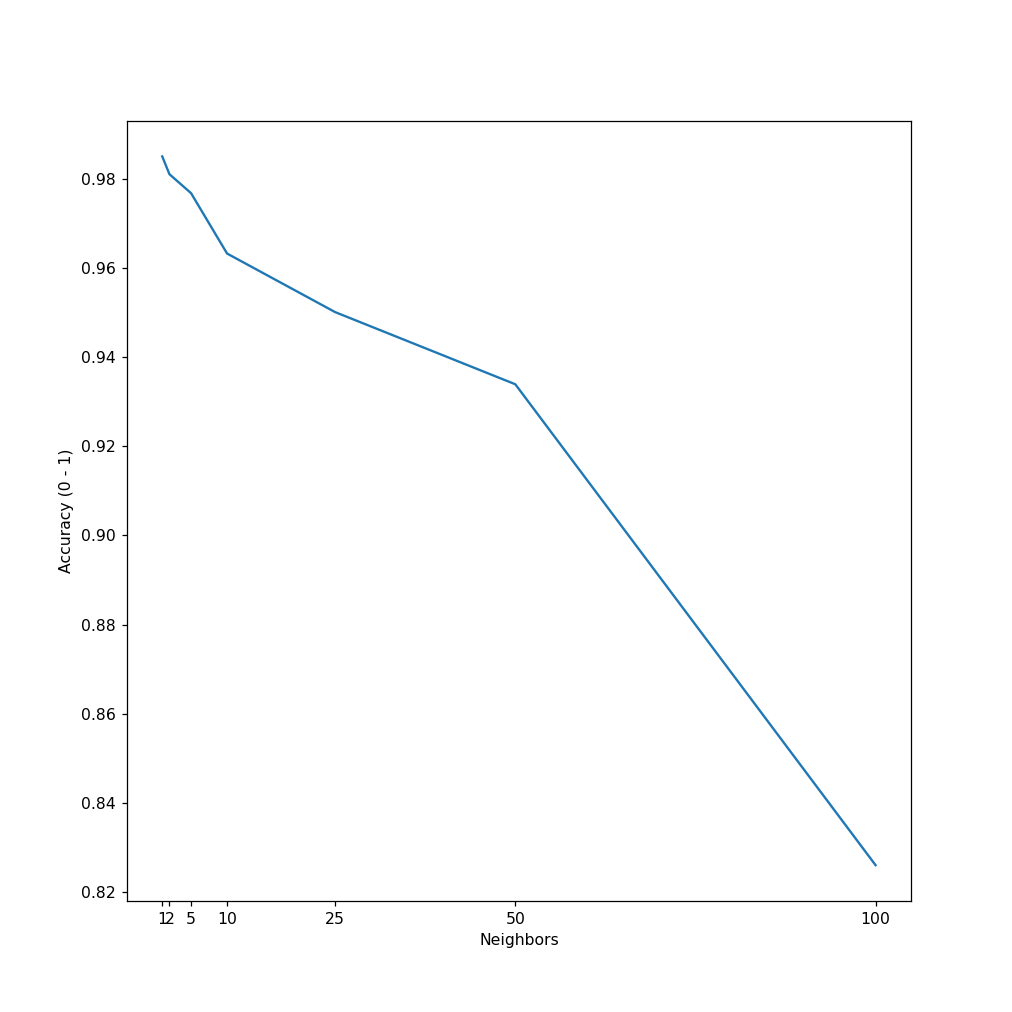

<IPython.core.display.Javascript object>


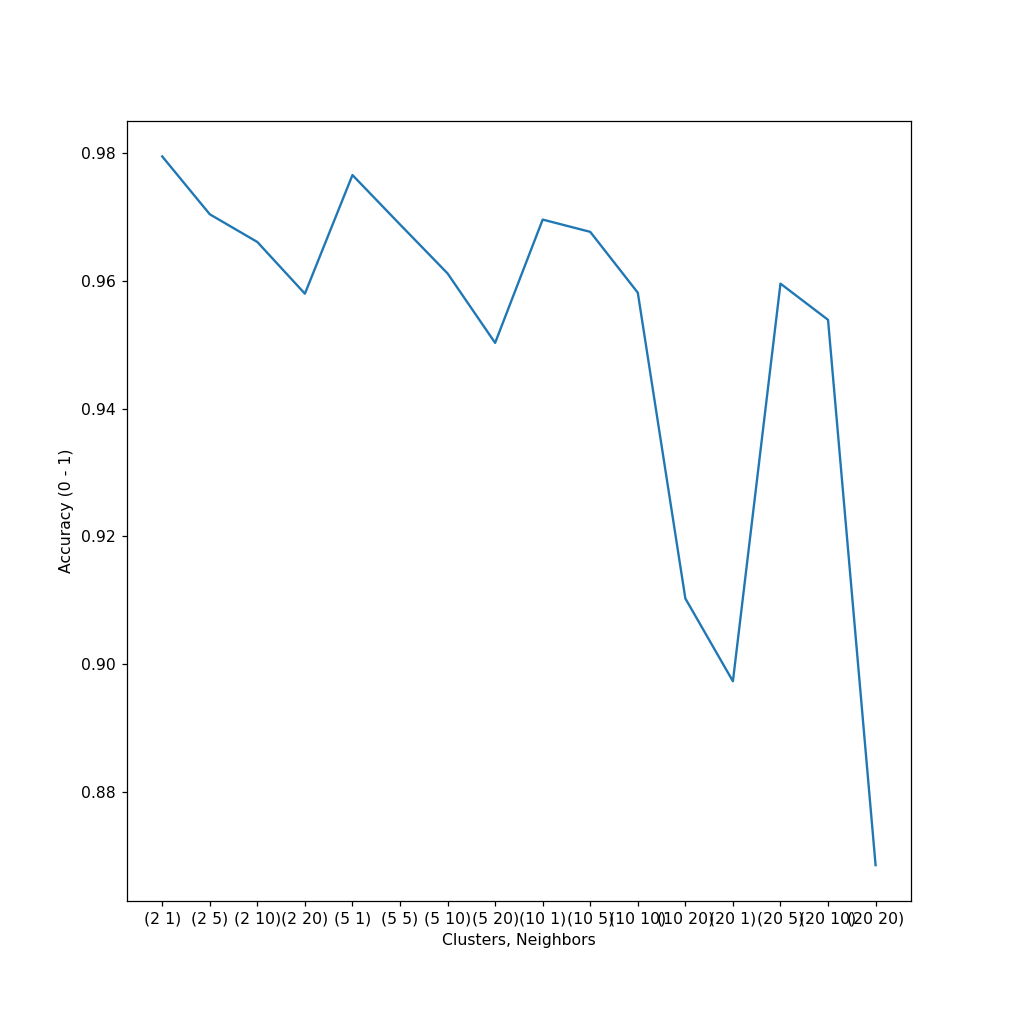

<IPython.core.display.Javascript object>


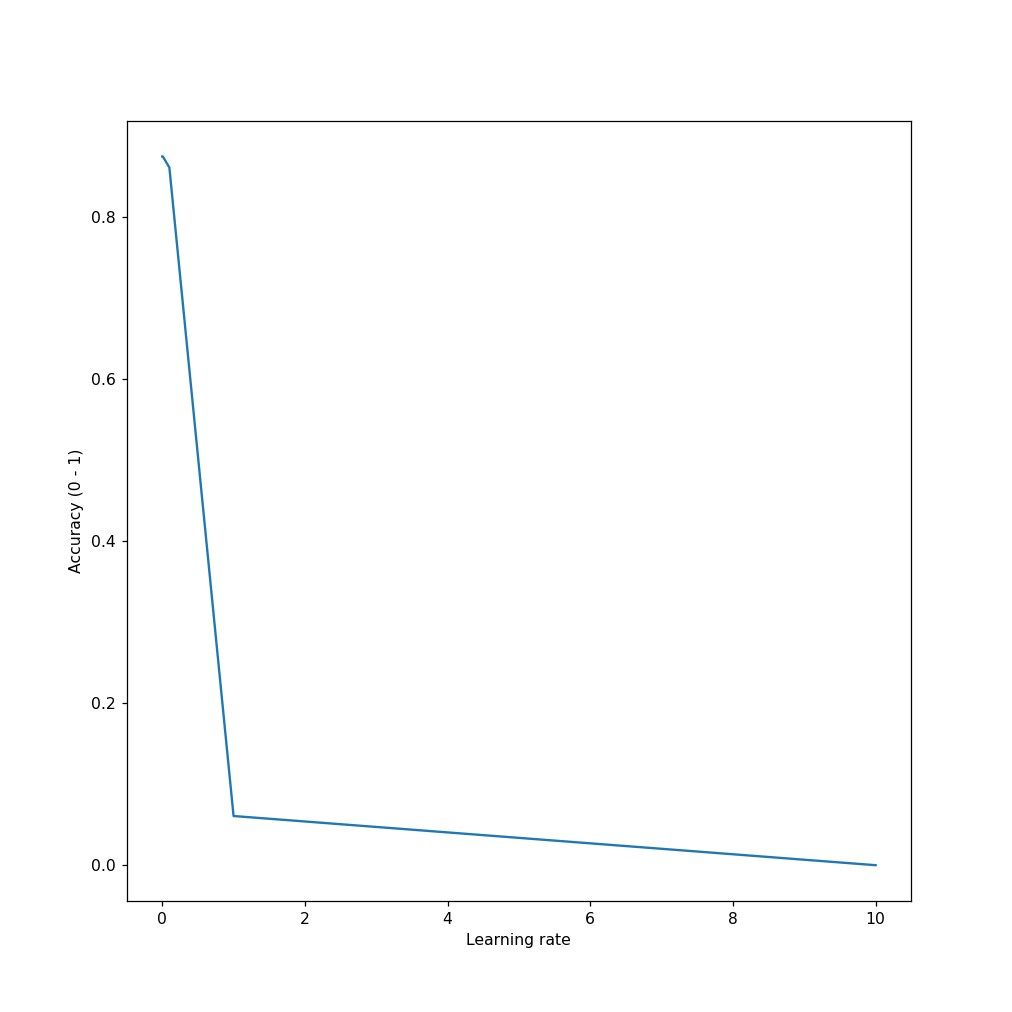

<IPython.core.display.Javascript object>


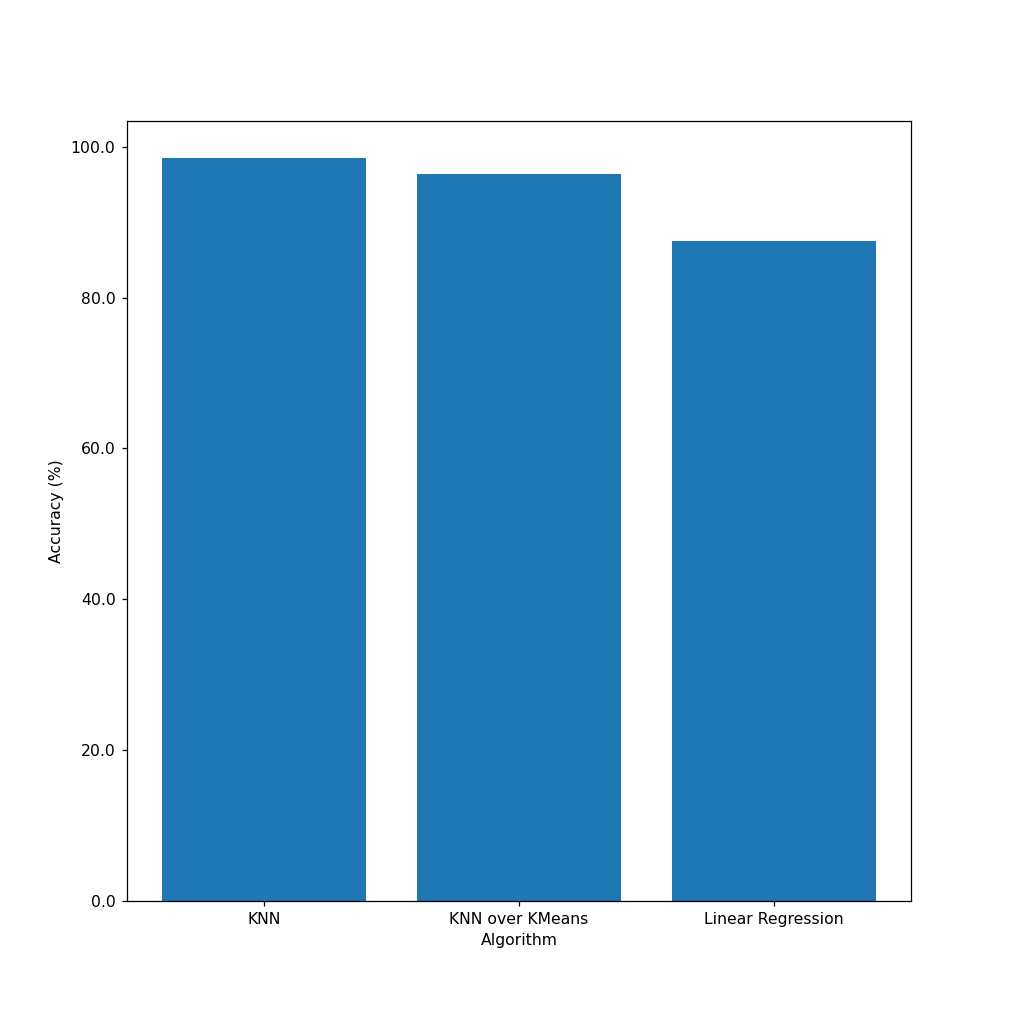

In [27]:
f = plt.figure("Accuracy of KNN", figsize=(9, 9))
a = plt.axes()
a.plot(knn, 1 - np.mean(knn_scores, axis = 0));
a = plt.xlabel('Neighbors')
a = plt.xticks(knn)
a = plt.ylabel('Accuracy (0 - 1)')

f = plt.figure("Accuracy of KNN over KMeans", figsize=(9, 9))
a = plt.axes()
a.plot(range(len(cknn) * len(kmeans)), 1 - np.mean(cknn_scores, axis = 1));
a = plt.xticks(range(0,16), labels = ["(%s %s)" % x for x in list(itertools.product(kmeans, cknn))])
a = plt.xlabel('Clusters, Neighbors')
a = plt.ylabel('Accuracy (0 - 1)')

f = plt.figure("Accuracy of Linear regression", figsize=(9, 9))
a = plt.axes()
a.plot(alpha, 1 - np.mean(lr_scores, axis = 0));
a = plt.xlabel('Learning rate')
a = plt.ylabel('Accuracy (0 - 1)')

f = plt.figure("Comparison of best accuracies", figsize=(9, 9))
a = plt.bar(['KNN', 'KNN over KMeans', 'Linear Regression'], [1 - np.amin(np.mean(knn_scores, axis = 0)), 1 - np.amin(np.mean(cknn_scores, axis = 0)), 1 - np.amin(np.mean(lr_scores, axis = 0))])
a = plt.xlabel('Algorithm')
a = plt.ylabel('Accuracy (%)')
a = plt.yticks(plt.yticks()[0][0:6], labels = np.rint(plt.yticks()[0][0:6] * 100))

# Saving best model to pickle file

In [70]:
if ((np.amin(np.mean(knn_scores, axis = 0)) <= np.amin(np.mean(cknn_scores, axis = 0))) and np.amin(np.mean(knn_scores, axis = 0)) <= np.amin(np.mean(lr_scores, axis = 0))):
    model = KNearestNeighbors()
    model.fit(loc_training_data_sig, loc_training_target)
    parameters = [best_knn]
    best_model = model
elif ((np.amin(np.mean(cknn_scores, axis = 0)) <= np.amin(np.mean(knn_scores, axis = 0))) and np.amin(np.mean(cknn_scores, axis = 0)) <= np.amin(np.mean(lr_scores, axis = 0))):
    model = clusteredKNN()
    model.fit(loc_training_data_sig, loc_training_target)
    parameters = [best_kmeans, best_cknn]
    best_model = model
elif ((np.amin(np.mean(lr_scores, axis = 0)) <= np.amin(np.mean(knn_scores, axis = 0))) and np.amin(np.mean(lr_scores, axis = 0)) <= np.amin(np.mean(cknn_scores, axis = 0))):
    model = LinearRegression()
    model.fit(loc_training_data_sig, loc_training_target)
    parameters = [best_alpha]
    best_model = model

In [115]:
import pickle

# save model and other necessary modules
all_info_want_to_save = {
    'best_features': more_used_features,
    'best_parameters': parameters,
    'best_model': best_model
}
save_path = open("sample_trained_model.pickle","wb")
pickle.dump(all_info_want_to_save, save_path)
